# CS4487 - Machine Learning
# Lecture 2a - Bayes Classifier
## Dr. Antoni B. Chan
### Dept. of Computer Science, City University of Hong Kong

# Outline
1. Bayes Classification and Generative Models
2. Parameter Estimation
3. Bayesian Decision Rule

In [1]:
# setup
%matplotlib inline
import IPython.core.display         # setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
from scipy import stats

/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV itera

# Classification Examples
- Given an email, predict whether it is spam or not spam.
  - **Email 1:**
> There was a guy at the gas station who told me that if I knew Mandarin
and Python I could get a job with the FBI.
  - **Email 2:**
> A home based business opportunity is knocking at your door.
> Donít be rude and let this chance go by.
> You can earn a great income and find your financial life transformed.
> Learn more Here.
> To Your Success.
> Work From Home Finder Experts

- Classification Examples
  - Given the _petal length_ and _sepal width_, predict the type of iris flower.

<center>
<table border='none'><tr>
<td style="vertical-align:top; text-align:center;">Features<br><img src="imgs/Petal-sepal.jpg" style="max-height:150px"></td>
<td style="vertical-align:top; text-align:center;"><b>Versicolor</b><br><img src="imgs/iris-versicolor.jpg" style="max-height:150px"></td>
<td style="vertical-align:top; text-align:center;"><b>Virginica</b><br><img src="imgs/iris-virginica.jpg" style="max-height:150px"></td>
</tr></table>
</center>

In [2]:

# load iris data each row is (petal length, sepal width, class)
irisdata = loadtxt('iris2.csv', delimiter=',', skiprows=1)

X = irisdata[:,0:2]  # the first two columns are features (petal length, sepal width)
y = irisdata[:,2]    # the third column is the class label (versicolor=1, virginica=2)

# a colormap for making the scatter plot: class 1 will be red, class 2 will be green
mycmap = matplotlib.colors.LinearSegmentedColormap.from_list('mycmap', ["#FF0000", "#FFFFFF", "#00FF00"])

irisfig = plt.figure()
plt.scatter(X[:,0], X[:,1], c=y, cmap=mycmap, edgecolors='k')
# c is the color value, drawn from colormap mycmap
plt.xlabel('petal length'); plt.ylabel('sepal width')
plt.axis([2.5, 7, 1.5, 4]); plt.grid(True);
plt.title('versicolor vs. virginica');
plt.close()

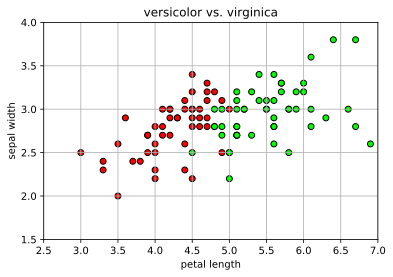

In [3]:
irisfig

# General Classification Problem
- Observation $\mathbf{x}$ (i.e., features)
  - typically a real vector, $\mathbf{x}\in \mathbb{R}^d$.
  - **Example**: a 2-dim vector containing the petal length and sepal width.
    - $\mathbf{x} = \begin{bmatrix}\text{petal length}\\ \text{sepal width}\end{bmatrix} = \begin{bmatrix}x_1\\ x_2\end{bmatrix}$
- Class $y$
  - takes values from a set of possible class labels $\cal{Y}$.
  - **Example:** $\cal{Y}=\{\textrm{"versicolor"}, \textrm{"virginica"}\}$.
    - or equivalently as numbers, $\cal{Y}=\{1,2\}$.
- **Goal**: given an observed features $\mathbf{x}$, predict its class $y$.

# Probabilistic model
- One type of classifier is to model the data.
- Model _how_ the data is generated using probability distributions.
  - called a **generative model**.
- Generative model
  - 1) The world has objects of various classes.
  - 2) The observer measures features/observations from the objects.
  - 3) Each class of objects has a particular distribution of features.

# Class model
- possible classes are $\cal{Y}$
  - for example, ${\cal Y}=\{\textrm{"versicolor"}, \textrm{"virginica"}\}$.
    - or more generally, ${\cal Y}=\{1,2\}$.
- in the world, the frequency that class $y$ occurs is given by the probability distribution $p(y)$.
  - $p(y)$ is called the **prior distribution**.

- **Example:**
  - $p(y=1) = 0.4$
  - $p(y=2) = 0.6$
  - "In the world of iris flowers, there are 40% that are Class 1 (versicolor) and 60% that are Class 2 (virginica)"

## Learn from our data 
- $p(y=1) = \frac{\text{number of examples of Class 1}}{\text{total number of examples}}$
- analogous for Class 2

In [4]:
N1 = count_nonzero(y==1)  # number of Class 1 examples
N2 = count_nonzero(y==2)  # number of Class 2 examples
N  = len(y)               # total
py = [double(N1)/N, double(N2)/N] # note: avoids integer division!
print(py)

[0.5, 0.5]


# Observation model

- we measure/observe feature vector $\mathbf{x}$
  - the value of the features _depend_ on the class.
- the observation is drawn according to the distribution $p(\mathbf{x}|y)$.
  - $p(x|y)$ is called the **class conditional distribution**
    - "probability of observing a particular feature vector $\mathbf{x}$ given the object is class $y$"
    - can "smooth out the samples" or "fill-in" values between samples.

## Learn from the data 
- histograms for feature "petal length" for each class

In [5]:
# extract petal length for class 1 and class 2
X1 = irisdata[y==1,0]   # y==1 selects all rows where class=1
X2 = irisdata[y==2,0]

# plot a histogram for each
ccdhist = plt.figure()
binedges = arange(2.5, 7.5, 0.1)
plt.hist(X1, binedges, facecolor='r', alpha=0.75, align='mid', label='y=1')
plt.hist(X2, binedges, facecolor='g', alpha=0.75, align='mid', label='y=2')
plt.legend()
plt.xlabel('petal length'); plt.ylabel('p(x|y)')
plt.title('feature histograms')
plt.axis([2.5, 7.5, 0, 10]); plt.grid(True)
plt.close()

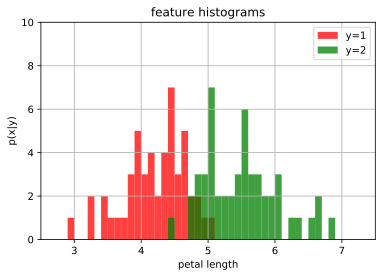

In [6]:
ccdhist

- **Problem:** looks a little bit noisy.
- **Solution:** assume a probability model for the class conditional $p(x|y)$

## Gaussian distribution (normal distribution)
- Each class is modeled as a separate Gaussian distribution of the feature value
  - $p(x|y=c) = \frac{1}{\sqrt{2\pi\sigma_c^2}}e^{-\frac{1}{2\sigma_c^2}(x-\mu_c)^2}$
  - Each class has its own mean and variance parameters $(\mu_c, \sigma_c^2)$.  

In [7]:
# show mean/stddev example
tpdf = stats.norm(loc=2.3, scale=1.5)
gfig = plt.figure()
mymean = tpdf.mean()
mystd  = tpdf.std()
tmpval = tpdf.pdf(mymean-mystd)
tmpval2 = tpdf.pdf(mymean-mystd*2)
xr = arange(-5,10,0.01)
plt.plot(xr, tpdf.pdf(xr), 'r-')
plt.plot([mymean]*2, [0, 0.3], 'k--')
plt.text(mymean+0.1, 0.28, 'mean $\mu$', horizontalalignment='left')
plt.annotate("", xy=(mymean-mystd, tmpval), xytext=(mymean+mystd, tmpval), 
            arrowprops={'arrowstyle':'<->', 'shrinkA':0, 'shrinkB':0})
plt.text(mymean+0.5, tmpval-0.005, '$2\sigma$', verticalalignment='top')
plt.annotate("", xy=(mymean-2*mystd, tmpval2), xytext=(mymean+2*mystd, tmpval2), 
            arrowprops={'arrowstyle':'<->', 'shrinkA':0, 'shrinkB':0})
plt.text(mymean+0.5, tmpval2-0.005, '$4\sigma$', verticalalignment='top')
plt.xlabel('x'); plt.ylabel('p(x|y)')
plt.title('Gaussian: ' + "$\mu=" + str(mymean) + "$; $\sigma=" + str(mystd) + "$")
plt.grid(True)
plt.close()

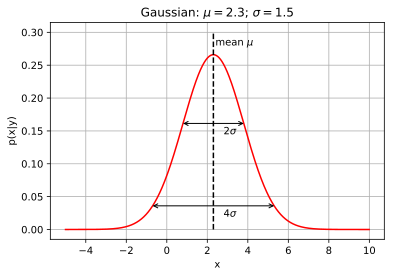

In [8]:
gfig

### Learn the parameters from data.
- Maximum likelihood estimation (MLE)
  - set the parameters ($\mu$, $\sigma^2$) to maximize the likelihood (probability) of the samples for that class.
  - Let $\{\mathbf{x}_i, y_i\}_{i=1}^N$ be the data for one class:
  $$ (\hat{\mu},\hat{\sigma}^2) = \mathop{\mathrm{argmax}}_{\mu, \sigma^2} \sum_{i=1}^N \log p(\mathbf{x}_i| y_i)$$

- Solution: 
  - sample mean: $\hat{\mu} = \frac{1}{N}\sum_{i=1}^N \mathbf{x}_i$
  - sample variance: $\hat{\sigma}^2 = \frac{1}{N} \sum_{i=1}^N (\mathbf{x}_i - \hat{\mu})^2$

In [9]:
G1mean,G1std = stats.norm.fit(X1)  # fit Gaussian to class=1 data
G2mean,G2std = stats.norm.fit(X2)  # fit for class=2 data
print("mn={:0.5f} std={:0.5f}".format(G1mean, G1std))
print("mn={:0.5f} std={:0.5f}".format(G2mean, G2std))

mn=4.26000 std=0.46519
mn=5.55200 std=0.54635


In [10]:
# create Gaussian class conditionals with the learned (mean,scale)
pxy = [ stats.norm(loc=G1mean, scale=G1std),   # class 1 (versicolor)
        stats.norm(loc=G2mean, scale=G2std) ]  # class 2 (virginica)

xr = arange(2.5,7,0.01)
gcd = plt.figure()
binedges = arange(2.5, 7.5, 0.1)
plt.hist(X1, binedges, density=True, facecolor='r', alpha=0.20, align='mid')
plt.hist(X2, binedges, density=True, facecolor='g', alpha=0.20, align='mid')

lab1 = "y=1 ($\mu$={:.2f}, $\sigma$={:.2f})".format(G1mean, G1std)
lab2 = "y=2 ($\mu$={:.2f}, $\sigma$={:.2f})".format(G2mean, G2std)

plt.plot(xr, pxy[0].pdf(xr), 'r', lw=2, label=lab1)
plt.plot(xr, pxy[1].pdf(xr), 'g', lw=2, label=lab2)
plt.legend()
plt.ylabel('p(x|y)'); plt.xlabel("petal length")
plt.title('Gaussian class conditionals')
plt.axis([2.5, 7, 0, 1]); plt.grid(True)
plt.close()

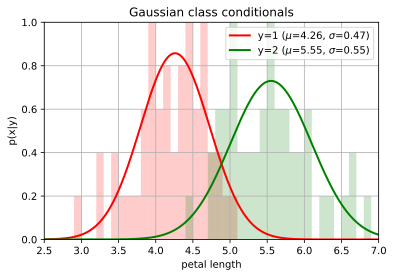

In [11]:
gcd

# Bayesian Decision Rule
- The Bayesian decision rule (BDR) makes the optimal decisions on problems involving probability (uncertainty).
  - minimizes the _probability of making a prediction error_.
- **Bayes Classifier**
  - Given observation $x$, pick the class $c$ with the _largest posterior probability_, $p(y=c|x)$.
  - **Example:**
    - if $p(y=1|x) > p(y=2|x)$, then choose Class 1
    - if $p(y=1|x) < p(y=2|x)$, then choose Class 2

- Problem: we don't have $p(y|x)$!
  - we only have $p(y)$ and $p(x|y)$.

# Bayes' Rule
- The posterior probability can be calculated using Bayes' rule:
$$p(y|x) = \frac{p(x|y)p(y)}{p(x)}$$
  - The denominator is the probability of $x$:
    - $p(x) = \sum_{y\in {\cal Y}} p(x|y)p(y)$
  - The denominator makes $p(y|x)$ sum to 1.

- Bayes' rule: $$p(y|x) = \frac{p(x|y)p(y)}{p(x|y=1)p(y=1) + p(x|y=2)p(y=2)}$$

- **Example**: 

In [12]:
# calculate posteriors for each x
jxy = [pxy[0].pdf(xr)*py[0],   # p(x|y=1)p(y=1)
       pxy[1].pdf(xr)*py[1]]   # p(x|y=2)p(y=2)
px = jxy[0] + jxy[1]           # p(x)

post = [ jxy[0] / px,      # posterior for class 1
         jxy[1] /px ]      # posterior for class 2

iris1dpost = plt.figure(figsize=(9,3))
plt.subplot(1,2,1)
plt.plot(xr, pxy[0].pdf(xr), 'r-', label="y=1")
plt.plot(xr, pxy[1].pdf(xr), 'g-', label="y=2")
plt.ylabel('likelihood'); plt.xlabel("petal length")
plt.title('class conditional p(x|y)')
plt.legend(framealpha=1, fontsize='medium')
plt.axis([2.5, 7, 0, 1.05]); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(xr, post[0], 'r-', label="p(y=1|x)")
plt.plot(xr, post[1], 'g-', label="p(y=2|x)")
plt.ylabel('probability'); plt.xlabel("petal length")
plt.axis([2.5, 7, 0, 1.2]); plt.grid(True)
plt.title('posterior p(y|x)');
plt.legend(loc=0, framealpha=1, fontsize='medium')
plt.close()


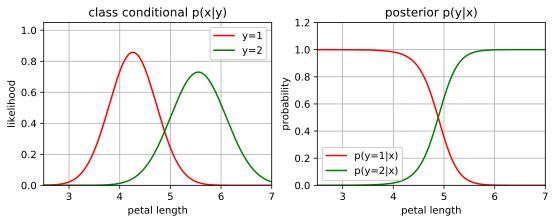

In [13]:
iris1dpost

- The _decision boundary_ is where the two posterior probabilites are equal
  - $p(y=1|x) = p(y=2|x)$

In [14]:
# find the index of the midpoint
midind = sum(post[0]>post[1])
midx   = 0.5*(xr[midind-1]+xr[midind])

iris1dpost2 = plt.figure()
plt.plot(xr, post[0], 'r-', label="p(y=1|x)")
plt.plot(xr, post[1], 'g-', label="p(y=2|x)")
plt.plot([midx, midx], [0,1.2], 'k--', label="decision boundary")
plt.ylabel('probability'); plt.xlabel("petal length")
plt.axis([2.5, 7, 0, 1.2]); plt.grid(True)
plt.title('posterior p(y|x)');
plt.arrow(midx-0.1,1.05,-0.8,0,width=0.01)
plt.arrow(midx+0.1,1.05,0.8,0,width=0.01)
plt.text(midx+0.1,1.10,"Class 2")
plt.text(midx-0.1,1.10,"Class 1", horizontalalignment='right')
plt.legend(loc=0, framealpha=1, fontsize='medium')
plt.close()

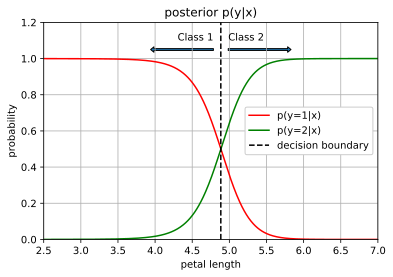

In [15]:
iris1dpost2

# Bayes rule revisited
- Bayes' rule: $p(y|x) = \frac{p(x|y)p(y)}{p(x)}$
- Note that the denominator is the same for each class $y$.
  - hence, we can compare just the numerators $p(x|y)p(y)$.
  - This also called the _joint likelihood_ of the observation and class
    - $p(x,y) = p(x|y)p(y)$

- **Example:**
  - BDR using joint likelihoods:
    - if $p(x|y=1)p(y=1)$ $>$ $p(x|y=2)p(y=2)$, then choose Class 1
    - otherwise, choose Class 2

In [16]:
# calculate joint likelihood for each x
iris1djoint = plt.figure(figsize=(9,3))

plt.subplot(1,2,1)
plt.plot(xr, post[0], 'r-', label="p(y=1|x)")
plt.plot(xr, post[1], 'g-', label="p(y=2|x)")
a3, = plt.plot([midx, midx], [0,1.2], 'k--')
plt.ylabel('probability'); plt.xlabel("petal length")
plt.axis([2.5, 7, 0, 1.05]); plt.grid(True)
plt.title('posterior p(y|x)');
plt.legend(loc=0, framealpha=1, fontsize='medium')
plt.subplot(1,2,2)
plt.plot(xr, jxy[0], 'r-', label="p(x,y=1)")
plt.plot(xr, jxy[1], 'g-', label="p(x,y=2)")
plt.plot([midx, midx], [0,1.2], 'k--')
plt.ylabel('likelihood'); plt.xlabel("petal length")
plt.title('joint likelihood p(x,y)')
plt.legend(loc=0, framealpha=1, fontsize='medium')
plt.axis([2.5, 7, 0, .55]); plt.grid(True)
plt.close()

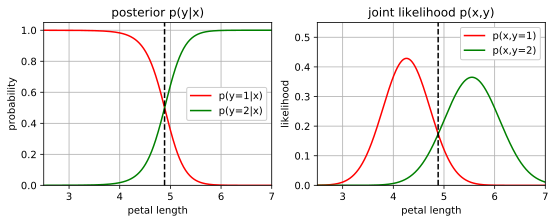

In [17]:
iris1djoint

- Can also apply a monotonic increasing function (like $\log$) and do the comparison.
  - Using log likelihoods:
    - $\log p(x|y=1)+\log p(y=1)$ $>$ $\log p(x|y=2)+\log p(y=2)$
  - This is more numerically stable when the likelihoods are small.

In [18]:
# show joint likelihood and LL plots
iris1dLL = plt.figure(figsize=(9,3))

plt.subplot(1,2,1)
plt.plot(xr, jxy[0], 'r-', label="p(x,y=1)")
plt.plot(xr, jxy[1], 'g-', label="p(x,y=2)")
plt.plot([midx, midx], [0,1.2], 'k--')
plt.ylabel('likelihood'); plt.xlabel("petal length")
plt.title('joint likelihood p(x,y)')
plt.legend(loc=0, framealpha=1, fontsize='medium')
plt.axis([2.5, 7, 0, .55]); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(xr, pxy[0].logpdf(xr) + log(py[0]), 'r-', label="log p(x,y=1)")
plt.plot(xr, pxy[1].logpdf(xr) + log(py[1]), 'g-', label="log p(x,y=2)")
plt.plot([midx, midx], [-20,5], 'k--')
plt.ylabel('log-likelihood'); plt.xlabel("petal length")
plt.title('log p(x,y)')
plt.axis([2.5, 7, -20, 0]); plt.grid(True)
plt.legend(loc=0, framealpha=1, fontsize='medium')
plt.close()

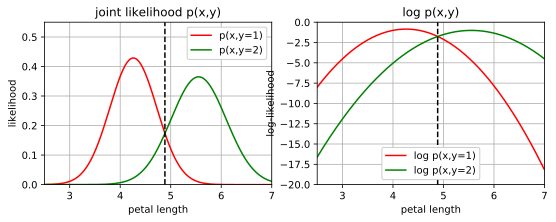

In [19]:
iris1dLL

# Bayes Classifier Summary
- **Training:**
  1. Collect training data from each class. 
  2. For each class $c$, estimate the class conditional densities $p(x|y=c)$:
    1. select a form of the distribution (e.g. Gaussian).
    2. estimate its parameters with MLE.
  3. Estimate the class priors $p(y)$ using MLE.
- **Classification:**
  1. Given a new sample $x^*$, calculate the likelihood $p(x^*|y=c)$ for each class $c$.
  2. Pick the class $c$ with largest posterior probability $p(y=c|x)$.
    - (equivalently, use $p(x|y=c)p(y=c)$ or $\log p(x|y=c)+\log p(y=c)$)